In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [2]:
df = yf.download('MSFT', start='2010-01-01', end='2021-12-31', progress=False)
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))

In [3]:
df.tail

<bound method NDFrame.tail of              adj_close   log_rtn
Date                            
2010-01-04   23.855659       NaN
2010-01-05   23.863359  0.000323
2010-01-06   23.716923 -0.006155
2010-01-07   23.470266 -0.010454
2010-01-08   23.632128  0.006873
...                ...       ...
2021-12-23  333.999390  0.004462
2021-12-27  341.743378  0.022921
2021-12-28  340.545837 -0.003510
2021-12-29  341.244415  0.002049
2021-12-30  338.619843 -0.007721

[3020 rows x 2 columns]>

In [4]:
df=df.dropna(axis=0)
df.isnull().sum()

adj_close    0
log_rtn      0
dtype: int64

In [15]:
df.describe()

,adj_close,log_rtn,moving_std_252,moving_std_21
count,3019.000000,3019.000000,2768.000000,2999.000000
mean,81.546731,0.000879,0.015460,0.014259
std,77.324296,0.015787,0.004089,0.007085
min,17.898998,-0.159453,0.008685,0.003449
25%,25.223101,-0.006655,0.013127,0.010090
50%,46.851585,0.000695,0.014861,0.012813
75%,106.056965,0.008754,0.016674,0.016213
max,342.402008,0.132929,0.028013,0.071225


In [18]:
import scipy
from scipy.stats import skew
# Skewness
# Skewness = 0: Then normally distributed.
# Skewness > 0: Then more weight in the left tail of the distribution.
# Skewness < 0: Then more weight in the right tail of the distribution.
skew(df.log_rtn, bias=False)

-0.24519195593241475

In [19]:
import scipy
from scipy.stats import kurtosis
# kurtosis for normal distribution is equal to 3.
# For a distribution having kurtosis < 3: It is called playkurtic.
# For a distribution having kurtosis > 3, It is called leptokurtic and it signifies that it 
                                        # tries to produce more outliers rather than the normal distribution.
kurtosis(df.log_rtn, bias=False)

10.170713833011543

### Non-Gaussian Distribution of Returns

In [5]:
# Probability Density Function (PDF) using mean an std dev of observed returns
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

C:\Users\Cesar\anaconda4\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Q-Q plot')

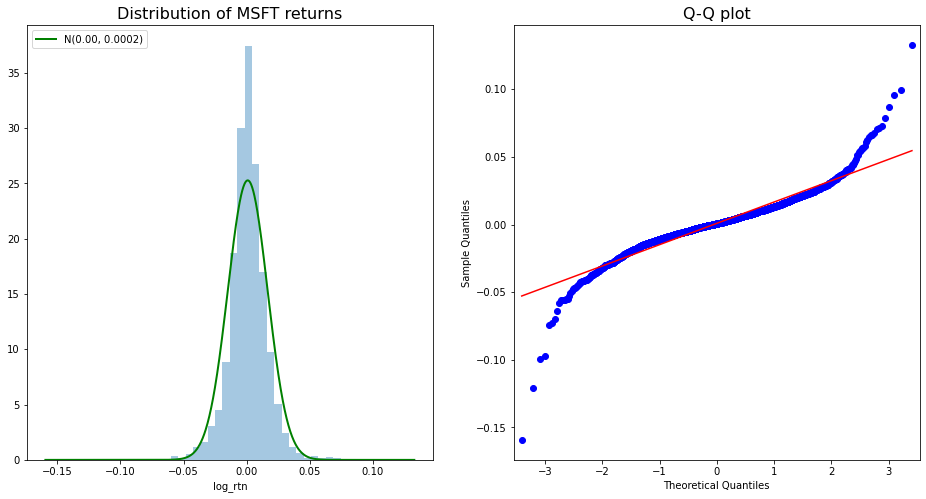

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# histogram
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribution of MSFT returns', fontsize=16)
ax[0].plot(r_range, norm_pdf, 'g', lw=2,
label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');
# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)

In [14]:
# Normality Test
import scipy
from scipy import stats
dist = getattr(scipy.stats, 'norm')
param = dist.fit(df.log_rtn)
norm_dist = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = len(df.log_rtn))

# D'agostino normality test
print(stats.normaltest(df.log_rtn))
# Shapiro test of normality
print(stats.shapiro(df.log_rtn))
# Kolmogorov-Smirnov Test
print(stats.kstest(df.log_rtn, "norm"))
print(stats.kstest(df.log_rtn, norm_dist))
# normality tests use a (0,1) normal distribution 
print(scs.jarque_bera(df.log_rtn))

NormaltestResult(statistic=570.4871638169365, pvalue=1.3191262990542257e-124)
ShapiroResult(statistic=0.9155194759368896, pvalue=4.0273912015244116e-38)
KstestResult(statistic=0.475284596591349, pvalue=0.0)
KstestResult(statistic=0.07452798940046373, pvalue=1.0301163669473816e-07)
Jarque_beraResult(statistic=12994.41951557915, pvalue=0.0)


### Volatility Clustering

<AxesSubplot:title={'center':'Daily MSFT returns'}, xlabel='Date'>

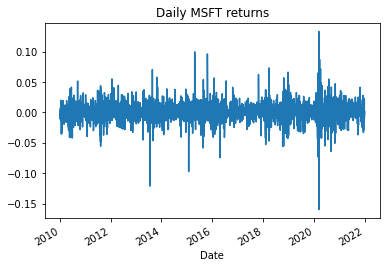

In [8]:
df.log_rtn.plot(title='Daily MSFT returns')

### Absence of autocorrelation in returns

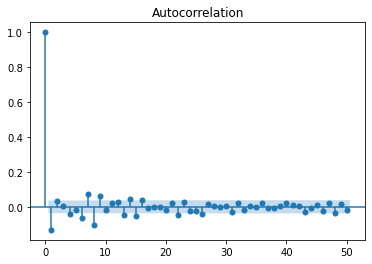

In [9]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05
acf = smt.graphics.plot_acf(df.log_rtn,
                            lags=N_LAGS,
                            alpha=SIGNIFICANCE_LEVEL)

### Small and decreasing autocorrelation in squared/absolute returns

[Text(0, 0.5, 'Absolute Returns'), Text(0.5, 0, 'Lag')]

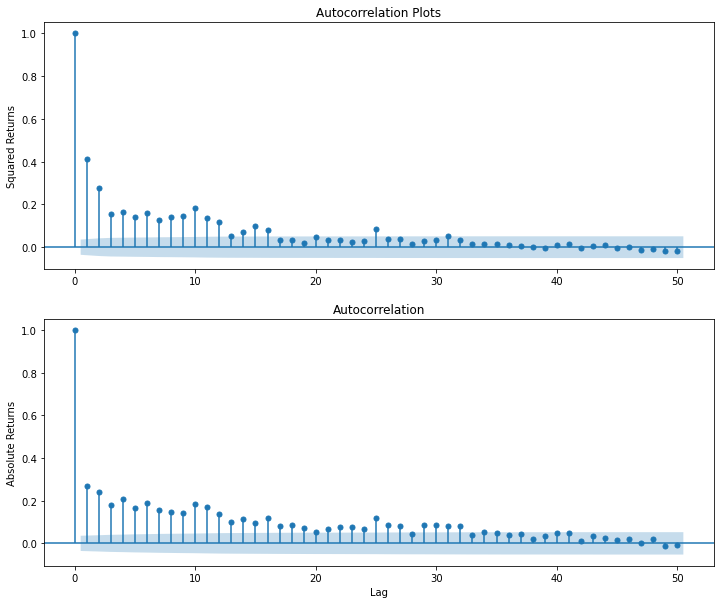

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
smt.graphics.plot_acf(df.log_rtn ** 2, lags=N_LAGS,
                      alpha=SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title='Autocorrelation Plots',
          ylabel='Squared Returns')
smt.graphics.plot_acf(np.abs(df.log_rtn), lags=N_LAGS,
                      alpha=SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(ylabel='Absolute Returns',
          xlabel='Lag')

### Leverage Effect

In [12]:
# Standard Deviation Rolling Window
df['moving_std_252'] = df[['log_rtn']].rolling(window=252).std()
df['moving_std_21'] = df[['log_rtn']].rolling(window=21).std()

<ipython-input-12-12d56c7f36b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['moving_std_252'] = df[['log_rtn']].rolling(window=252).std()
<ipython-input-12-12d56c7f36b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['moving_std_21'] = df[['log_rtn']].rolling(window=21).std()


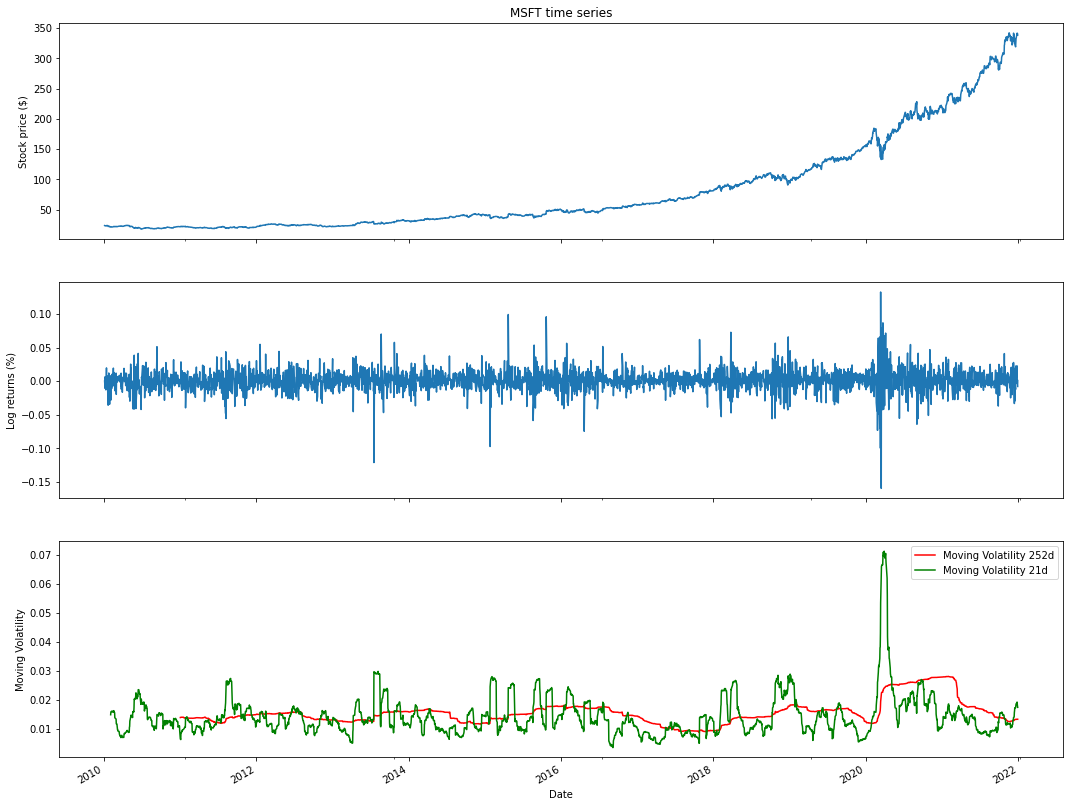

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15),
                       sharex=True)
df.adj_close.plot(ax=ax[0])
ax[0].set(title='MSFT time series',
          ylabel='Stock price ($)')

df.log_rtn.plot(ax=ax[1])
ax[1].set(ylabel='Log returns (%)')

df.moving_std_252.plot(ax=ax[2], color='r',
                       label='Moving Volatility 252d')
df.moving_std_21.plot(ax=ax[2], color='g',
                      label='Moving Volatility 21d')
ax[2].set(ylabel='Moving Volatility',
          xlabel='Date')
ax[2].legend()

### Volatility Index (VIX)

In [21]:
# Download Prices
vix = yf.download(['^GSPC', '^VIX'],
                 start='1985-01-01',
                 end='2018-12-31',
                 progress=False)
vix = vix[['Adj Close']]
vix.columns = vix.columns.droplevel(0)
vix = vix.rename(columns={'^GSPC': 'sp500', '^VIX': 'vix'})

In [22]:
# Log Returns
vix['log_rtn'] = np.log(vix.sp500 / vix.sp500.shift(1))
vix['vol_rtn'] = np.log(vix.vix / vix.vix.shift(1))
vix.dropna(how='any', axis=0, inplace=True)

[Text(0.5, 1.0, 'S&P 500 vs. VIX ($\\rho$ = -0.71)'),
 Text(0, 0.5, 'VIX log returns'),
 Text(0.5, 0, 'S&P 500 log returns')]

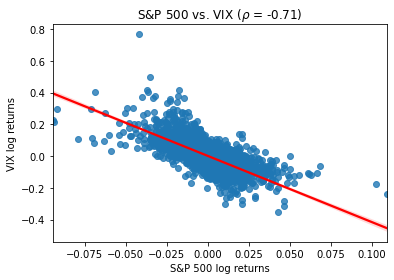

In [24]:
corr_coeff = vix.log_rtn.corr(vix.vol_rtn)

ax = sns.regplot(x='log_rtn', y='vol_rtn', data=vix,
                 line_kws={'color': 'red'})
ax.set(title=f'S&P 500 vs. VIX ($\\rho$ = {corr_coeff:.2f})',
       ylabel='VIX log returns',
       xlabel='S&P 500 log returns')